##### 1. torchvision 概览

> torchvision 是 torch 官方提供的视觉任务工具包，包含用于图像与视频数据的常用数据集加载、预训练模型、图像变换（transform）以及可视化工具。torchvision 独立于 torch，需要专门安装，torchvision 主要包含以下四部分：

- 1）torchvision.models: 模型包括 分类、检测、分割、视频理解四大类：

- - 1.1）在分类方面提供深度学习中各种经典的网络结构，如：Alex-Net、VGG、ResNet、Inception 等

- - 1.2）检测方面提供了常见的检测用的网络结构，FasterRCNN、RetinaNet、MaskRCNN 等

- - 1.3）分割方面提供了常见的分割用的网络结构，FCN, DeepLabV3, LRASPP 等

- - 1.4）视频理解方面不打算涉及，暂时不做学习

- 2）torchvision.datasets：提供常用的数据集，设计上继承 torch.utils.data.Dataset，主要包含分类、检测、分割、视频理解四大类常见数据集：

- - 2.1）分类方面主要包括：MNIST、FashionMNIST、CIFAR10/100、ImageNet、SVHN、Places365 等

- - 2.2）检测、分割方面主要包含：VOC、COCO、Cityscapes、CelebA、Caltech101/256 等

- - 2.3）视频理解方面不打算涉及，暂时不做学习

- 3）torchvision.transforms：提供常用的数据预处理操作，主要包括对 Tensor 及 PIL Image 对象的操作，新版的 transforms 有两套接口：

- - 3.1）传统版 (transforms)：操作 PIL 图像或 Tensor

- - 3.2）新版 (transforms.v2)：统一操作 tv_tensors（带标签的张量类型），支持批处理和自动类型推断，更安全且更快

- 4）torchvision.utils：工具类，如保存张量作为图像到磁盘，给一个小批量创建一个图像网格，该模块使用不太多，等用到会进行更新

In [2]:
# 与 torch 主体完全兼容，但安装时需要与 torch 版本和 CUDA 版本匹配，要查询 torch 和 torchvision 的版本，可以使用下面语句
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.8.0+cu126
0.23.0+cu126


##### 2. torchvision.models 的学习

> 1）torchvision.models: 模型包括 分类、检测、分割、视频理解四大类：

- - 1.1）在分类方面提供深度学习中各种经典的网络结构，如：Alex-Net、VGG、ResNet、Inception 等

- - 1.2）检测方面提供了常见的检测用的网络结构，FasterRCNN、RetinaNet、MaskRCNN 等

- - 1.3）分割方面提供了常见的分割用的网络结构，FCN, DeepLabV3, LRASPP 等

- - 1.4）视频理解方面不打算涉及，暂时不做学习

> torchvision.models 里面包含了很多的常见的模型，可以直接的加载使用，也可以直接加载预训练模型在自己想进行的任务上微调使用

- 1）通过 pretrined=True 可以加载预训练模型，pretrained 默认值是 False，不赋值和赋值 False 效果一样，选择了 pretrained 为 True 的话，点击运行会执行下载预训练参数的操作，不加载预训练模型没有这步操作，可以直接只使用网络架构

- 2）预训练模型使用上面的参数进行下载的时候现在会出现警告，主要是因为 torch 进行了更新，现在调用预训练模型的方法是在参数 weights 上指定调用的预训练模型的名字，参考下面的写法

- 3）直接输出当前的模型或者遍历输出其参数矩阵的名字和大小能检查当前的网络的形状，可以使用 torchsummary 库函数下的 summary 包来检查网络的结构，更加的直观

In [3]:
import torchvision.models as models
from torchsummary import summary as sumy

# torch.device 是一个类，表示一个设备或者对象
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# resnet18 = models.resnet18(pretrained=True) # 旧版本写法会出现警告，该方法将被淘汰，不建议使用
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet50 = models.resnet50(weights=None)
print(resnet50)
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
squeezenet = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
densenet = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1)
resnet152 = models.resnet152(weights=None)

# 可以使用该方法打印加载的预训练模型的参数
# 第一次接触 model.named_parameters()，他是 torch.nn.Module 类的一个方法。
# 它返回一个可迭代对象（generator），其中每个元素都是一个二元组 (name, parameter)，下面输出前十层的名字和参数矩阵的 shape 展示
print("Model architecture (show first 10 layers):")
for i, (name, param) in enumerate(resnet18.named_parameters()):
    print(f"Layer {i}: ", name, param.shape)
    if i == 9: break

# .to() 是 torch.Tensor 类的一个实例方法
# 当整个模型 .to() 的时候，此时 .to() 是 torch.nn.Module 类 的一个方法，它会自动遍历所有子层的参数和缓冲区（buffers），把它们都放到目标设备上
vgg16 = vgg16.to(device)

# summary 函数的参数：model：要查看的模型对象、input_size：输入的张量尺寸、device：指定设备上生成 summary，其他参数不重要用到可查
# 输出的 Output Shape 的第一个维度为 -1 代表是任意 batch_size 大小
sumy(vgg16, input_size=(3, 224, 224), device=str(device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

> 下面介绍常见的模型加载和保存的方法

- 1）vgg16.state_dict() 得到模型的参数

- 2）加载本地的模型参数使用方法 vgg16.load_state_dict()

- 3）需要结合加载文件转化为字典的函数 torch.load_dict() 一起使用，也就是 vgg16.load_state_dict(torch.load_dict(xxxx.pth))

- 4）保存模型的参数需要得到模型和的字典，然后使用 torch.save() 函数来保存，torch.save(vgg16.state_dict(), "xxxx.pth")

- 5）torch.save() 可以保存训练过程中的其他参数，方便中断之后继续训练，保存的时候写成键值对的形式即可，这样的保存形式加载的时候需要指定对应的键

In [41]:
vgg16_state_dict = vgg16.state_dict()
resnet18_state_dict = resnet18.state_dict()

torch.save(vgg16_state_dict, "./checkpoints/vgg16_state_dict.pth")
torch.save(resnet18_state_dict, "./checkpoints/resnet18_state_dict.pth")

vgg16.load_state_dict(torch.load("./checkpoints/vgg16_state_dict.pth"))

torch.save({
    "epoch": None,
    "model_state_dict": vgg16_state_dict,
    "optimizer_state_dict": None, # 假设训练使用的是带动量的 SGD 优化器，优化器参数保存了之前的动量，所以要从断点继续训练，这个参数是必须保存的
    "lr": None, # 断点恢复训练必须保存
    "loss": None
}, "./checkpoints/vgg16.pth")

vgg16.load_state_dict(torch.load("./checkpoints/vgg16.pth")["model_state_dict"])

<All keys matched successfully>

- 1）但是正常的使用过程中可能会修改模型的层数，想要接着使用预训练的参数就会出现无法加载的问题，所以必须在 pth 文件里面删掉或者加上相应的修改的层

- 2）加入现在 resnet18 的分类任务变为了分类为 10 类，就需要对最后的全连接层进行修改，层的名字和 shape 都是匹配的话，成功的加载，名字不匹配但是形状匹配的话，strict=False 会忽略错误，名字匹配但是形状不匹配，就会报错

- 3）pretrained_state_dict = {k : v for k, v in pretrained_state_dict.items() if k in model_state_dict} 这个写法很显然只会比较键是不是完全一样，即使修改了形状也不会关心，所以需要加上判断，v.shape 和 model_state_dict[k].shape 要是一样的才行，这样的话，只会从预训练模型里面加载确定没有修改的层

In [42]:
import torch.nn as nn

model = models.resnet18(weights=None) # 加载空模型

model.fc = nn.Linear(512, 10) # 修改全连接层的大小

pretrained_state_dict = resnet18.state_dict() # 预训练模型参数
model_state_dict = model.state_dict() # 加载的模型参数

# 验证键是一样的，也就是层没有改变
print(pretrained_state_dict.keys() == model_state_dict.keys())
print(pretrained_state_dict["fc.bias"].size())

pretrained_state_dict = {k : v for k, v in pretrained_state_dict.items() if k in model_state_dict and v.shape == model_state_dict[k].shape}

# res = model.load_state_dict(torch.load('./resnet18_state_dict.pth'), strict=False) 报错，因为无法对应，原本的预训练模型的全连接层的大小为 [512, 1000]，现在被我修改为了 [512, 10]
res = model.load_state_dict(pretrained_state_dict, strict=False) # 完美的加载，验证了自己的想法，现在删掉了全连接层的参数，其他的参数对应上了

print("Missing keys:", res.missing_keys) # 模型中存在，但是在预训练参数里面找不到
print("Unexpected keys:", res.unexpected_keys) # 预训练参数中存在模型中没定义，这个不会遇到，因为我强制的比对了键值对，模型中没定义的一定会被删掉的

print(model.fc.weight.mean(), model.fc.weight.std())  # 随机分布
print(resnet18.fc.weight.mean(), resnet18.fc.weight.std())  # 不同分布


True
torch.Size([1000])
Missing keys: ['fc.weight', 'fc.bias']
Unexpected keys: []
tensor(-0.0004, grad_fn=<MeanBackward0>) tensor(0.0253, grad_fn=<StdBackward0>)
tensor(5.8502e-08, grad_fn=<MeanBackward0>) tensor(0.0695, grad_fn=<StdBackward0>)


> 上面简单的介绍了模型的加载和报错，和加载预训练参数的方法等，这个是 torchvision.models 库函数里面常见的操作了，总结下列函数：

- 1）models.model() 加载名字为 model 的模型，一般的参数为 weights，代表加载预训练参数，不想加载的话初始化为 weights=None

- 2）model.named_parameters() 返回一个生成器，每个元素是 (name, parameter) 二元组

- 3）summary() 来自 torchsummary 或 torchinfo 包，需单独安装，能模拟一张输入图片走完整个网络，输出表格信息（每层输出尺寸、参数量、总参数数等）

- 4）torch.save() 保存模型，可以保存任意 Python 对象包括模型参数、优化器状态、epoch 等

- 5）torch.load_state_dict() 加载模型

- 6）torch.load() 加载文件转化为字典

- 7）model.state_dict() 返回全部参数加上缓冲区（不带梯度信息），named_parameters() 返回仅可训练参数（带梯度）

##### 3. torchvision.datasets、torchvision.transforms 的学习

> - 2）torchvision.datasets：提供常用的数据集，设计上继承 torch.utils.data.Dataset，主要包含分类、检测、分割、视频理解四大类常见数据集：

- - 2.1）分类方面主要包括：MNIST、FashionMNIST、CIFAR10/100、ImageNet、SVHN、Places365 等

- - 2.2）检测、分割方面主要包含：VOC、COCO、Cityscapes、CelebA、Caltech101/256 等

- - 2.3）视频理解方面不打算涉及，暂时不做学习

> - 3）torchvision.transforms：提供常用的数据预处理操作，主要包括对 Tensor 及 PIL Image 对象的操作，新版的 transforms 有两套接口：

- - 3.1）传统版 (transforms)：操作 PIL 图像或 Tensor

- - 3.2）新版 (transforms.v2)：统一操作 tv_tensors（带标签的张量类型），支持批处理和自动类型推断，更安全且更快

In [43]:
from torchvision import datasets
from torchvision import transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# root 数据集的存放路径，没有的话，会自动存放到该文件夹
# train 是否加载训练集，否则的话就是测试集
# transform torchvision.transforms 包含对图像进行变换的函数，ToTensor()、Normalize()
# target_transform torchvision.transforms 对标签变换的函数，一般不使用
# download 如果本地没有数据集，是否从网上下载
mnist = datasets.MNIST("data/", download=True, train=False, transform=transform)

img = mnist[0][0]
label = mnist[0][1]
to_img = T.ToPILImage()
display(to_img(img))
print(label)

7


- 1）当第一次调用 datasets.MNIST(download=True) 时，它会自动执行以下步骤检查 raw 文件夹如果没有 .gz 文件，就从官网（yann.lecun.com）下载，自动解压 .gz 文件

- 2）存入 data/MNIST/processed/，解析二进制数据为 Tensor，把像素值解析成 torch.Tensor 格式，把标签解析成 torch.LongTensor，缓存结果，将解析好的数据保存为两个 .pt 文件

- 3）training.pt 包含 (train_images, train_labels)，参考上面是输出 dataset 是一个存储文件，保存了 Tensor 类型的文件和对应的标签，test.pt 包含 (test_images, test_labels)

- 4）因为 datasets.MNIST 继承自 torch.utils.data.Dataset，实现了 \_\_getitem\_\_ 和 \_\_len\_\_ 两个函数，可以直接 train_loader = DataLoader(train_data, batch_size=64, shuffle=True)，不需要也不能进行其他任何多余的操作，这个是 torchvision.datasets 的很大的局限性，只能加载指定名字的指定格式的数据集，想要将自己的数据集转化为 DataLoader 还是需要使用 torch.utils.data.Dataset 实现 \_\_getitem\_\_ 和 \_\_len\_\_ 函数，然后转化为 Dataset 类型的数据集，再进行 DataLoader 的批量加载

In [44]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist, batch_size=64, shuffle=True)

train_iter = iter(train_loader)
batch_img, batch_label = next(train_iter)

print(batch_img.shape, batch_label.shape)
for batch_idx, (imgs, labels) in enumerate(train_loader):
    print(batch_idx, imgs.shape, labels.shape)
    if batch_idx == 5: break

# train_data.data 输出所有图片，train_data.targets 输出所有的标签
print(mnist.data.shape, mnist.targets.shape)

image, label = mnist[0]
print(image.shape, label)

torch.Size([64, 1, 28, 28]) torch.Size([64])
0 torch.Size([64, 1, 28, 28]) torch.Size([64])
1 torch.Size([64, 1, 28, 28]) torch.Size([64])
2 torch.Size([64, 1, 28, 28]) torch.Size([64])
3 torch.Size([64, 1, 28, 28]) torch.Size([64])
4 torch.Size([64, 1, 28, 28]) torch.Size([64])
5 torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([10000, 28, 28]) torch.Size([10000])
torch.Size([1, 28, 28]) 7


In [45]:
from torchvision import transforms as T

# 包含了常见的图像处理的函数
dir(T)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

> 常见的图像处理函数的总结，用到可以自行查找

- 1）Compose()：用来管理所有的 transforms 操作

- 2）ToTensor()：把图片数据转换成张量并转化范围在 [0,1] 区间内

- 3）Normalize(mean, std)：归一化

- 4）Resize(size)：输入的 PIL 图像调整为指定的大小，参数可以为 int 或 int 元组

- 5）CenterCrop(size)：将给定的 PIL Image 进行中心切割，得到指定 size 的 tuple

- 6）RandomCrop(size, padding=0)：随机中心点切割

- 7）RandomHorizontalFlip(size, interpolation=2)：将给定的 PIL Image 随机切割，再 resize

- 8）RandomHorizontalFlip()：随机水平翻转给定的 PIL Image

- 9）RandomVerticalFlip()：随机垂直翻转给定的 PIL Image

- 10）ToPILImage()：将 Tensor 或 numpy.ndarray 转换为 PIL Image

- 11）FiveCrop(size)：将给定的 PIL 图像裁剪成 4 个角落区域和中心区域

- 12）Pad(padding, fill=0, padding_mode=‘constant’)：对 PIL 边缘进行填充

- 13）RandomAffine(degrees, translate=None, scale=None)：保持中心不变的图片进行随机仿射变化

- 15）RandomApply(transforms, p=0.5)：随机选取变换

##### 4.torchvision.io 的学习，对比 PIL 的一些文件处理方法

> torchvision.io 主要学习的就是文件的读取，但是很不幸的是本台机子上面现在没有太大的数据集，因为较小的数据集不能模拟出真实的训练效果，将较小的数据集加载一遍之后，其会暂时的保存在 page cache 里面，再次读取相同的文件系统直接从 page cache 里面把数据交给程序，不再访问磁盘，第二次几乎是瞬间完成的，即使重启了 Python 进程，只要系统没回收内存，仍然是热缓存

- 1）第一次读取文件是真实的 I/O（磁盘 -> RAM -> CPU）包括解码

- 2）第二次读取文件只是 RAM -> CPU 跳过了磁盘的阶段

> 较小的数据集在机器的内存能完全容纳的时候，OS 会一直留在 cache 里面，无论用 PIL 或者是 torchvision.io 第二轮几乎一样快，没办法比较磁盘的读取性能

> 内存可以简单的理解为程序使用的部分是缓存部分，当前读取的文件就是在这个缓存部分里面的，假如当前的缓存部分的大小是 26G，要读取 30G 的图片文件，LRU 策略来实现内存中图片文件的删除，只有当前的内存迫不得已的时候才会释放，将新的文件读取进入内存，释放掉旧的文件

> 数据集的大小决定了操作系统缓存和 I/O 行为是否进入真实状态，对应不同的数据集的详细解释如下

- 1）小数据集（远小于内存的数据集）：全部能放入 page cache，一次加载后全部留在 RAM，之后的所有 epoch 的读取几乎都是内存访问没有真实的磁盘 I/O，不能反映真实的训练瓶颈，尤其是 I/O 和解码部分

- 2）中等数据集（和内存大小接近的数据集）：首次加载的时候就能填满 page cache，第二轮开始触发 LRU 替换，部分页换入换出，每次 I/O 都有可能命中或者不命中 cache，接近冷热混合状态

- 3）大数据集（远大于内存的数据集）：page cache 无法容纳主要数据，每次 batch 都涉及新的磁盘读取，旧页频繁被淘汰，若 SSD/HDD 较慢，会出现 I/O 阻塞，GPU 等待，模拟工业训练的负载情况

> 当系统内存被完全占用的时候，再出现申请缓存的情况，内核需要从 RAM 挤出空间，尝试丢弃部分的 page cache，不够的话就回收部分的匿名页，匿名页没办法丢弃，只能写到 swap 区，常见的被换出的对象会有 python 变量、张量等内容，当访问到这些量的时候需要从磁盘慢慢读回来，CPU 阻塞在 I/O 上，GPU 等待数据，训练速度骤降

os 库函数里面一些常见的函数如下：

- 1）os.listdir() 将给定目录下的所有的文件或者文件夹的名字取出来形成一个列表，一次性查看所有的项，只看一层和下面的 os.walk() 形成了鲜明的对比

- 2）os.walk() 遍历文件夹目录树，遍历指定目录下的所有的子目录和文件 os.walk() 每次迭代都会返回一个三元组（root, dirs, files）root 代表当前遍历到的目录路径，dirs 是一个列表，当前的目录下的子目录名称列表，files 代表当前目录下的文件名称列表，逐步生成相较于 os.listdir() 更加的节省内存，下一次迭代会将子目录列表的第一个位置做 root，进行深度优先搜索，常用在下面的计算文件大小方面

- 2）os.path.join() 将给定的两个路径进行拼接

- 3）os.path.basename() 输出文件名

- 4）os.path.splitext() 输出拓展名

- 5）os.path.abspath() 返回绝对路径

- 6）os.path.dirname() 返回文件的目录部分

- 7）os.path.split() 同时返回（dirname, basename）

- 8）os.path.exists()、os.path.isfile()、os.path.isdir() 判断是否存在是否是文件是否是目录

- 9）os.path.getsize() 获取文件大小，字节数

- 10）os.makedirs() exist_ok 默认 False 代表不允许当前的文件存在，True 代表允许，一般写为 True

In [6]:
import os

for idx, (root, dirs, files) in enumerate(os.walk("./mnist_test_torch")):
    print(root, dirs, files)
    if idx == 0: break

./mnist_test_torch ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] []


In [8]:
# 构造一个较大的数据集

import os
import shutil
from tqdm import tqdm

def get_dir_size(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / 1e9 # GB

src_root = "./CASIA-WebFace" # 原始数据路径
dst_root = "./CASIA-WebFace-Expanded" # 新的数据集路径
repeat = 40 # 每个标签复制多少份
os.makedirs(dst_root, exist_ok=True)

base_size = get_dir_size(src_root)
print(f"CASIA-WebFace: {base_size:.2f} GB")
print(f"CASIA-WebFace-Expanded: {base_size * repeat:.2f} GB\n")

CASIA-WebFace: 4.32 GB
CASIA-WebFace-Expanded: 172.77 GB



> shutil 全名是 shell utilities（shell 工具），是 python 的标准库，不需要额外安装，常见的函数汇总如下：

- 1）shutil.copy(a, b) 将文件从 a 复制到 b（复制内容和权限，不复制时间戳）

- 2）shutil.copy2(a, b) 类似 copy，但保留元信息（时间戳，权限等）

- 3）shutil.copyfile(a, b) 只复制文件内容，不保留权限信息

- 4）shutil.copytree(a, b) 复制整个目录树，包含文件和子文件夹

- 5）shutil.move(a, b) 移动文件和文件夹，相当于剪切粘贴

- 6）shutil.rmtree() 递归删除整个目录树，包含文件和子文件夹

- 7）shutil.make_archive(base_name, format, root_dir)、shutil.unpack_archive(filename, extract_dir) 打包和解压文件，shutil.get_archive_formats() 查看支持的压缩格式

- 8）disk_usage() 查看磁盘使用情况、which() 查找命令的绝对路径（shutil.which("python")）

In [9]:
for label in os.listdir(src_root):
    label_path = os.path.join(src_root, label)
    for i in range(repeat):
        dst_label = f"{label}_{i:02d}"
        dst_dir = os.path.join(dst_root, dst_label)
        os.makedirs(dst_dir, exist_ok=True)

        for fname in os.listdir(label_path):
            src_file = os.path.join(label_path, fname)
            dst_file = os.path.join(dst_dir, f"{i:02d}_{fname}")
            if os.path.exists(dst_file):
                continue # 避免重复复制
            shutil.copy2(src_file, dst_file)
print("successfully!!")

final_size = get_dir_size(dst_root)
print(f"Actual space occupancy: {final_size:.2f} GB")

successfully!!
Actual space occupancy: 172.77 GB


> 冷启动只是在第一次完整扫描磁盘时很慢，后续训练几乎都在热态缓存下进行，模拟真实的训练过程下面就忽略冷启动阶段，提前读一遍文件主动的填满缓存，冷启动对实验瓶颈的研究意义不大，所以实验之前先进性一个预热，为了确保每个方法读取文件都在同一个环境下，因为 jupyter 下不能设置 num_workers 不为 0 的数字，所以实验都放在了 main.py 下跑，下面仅仅做一个可视化的图表

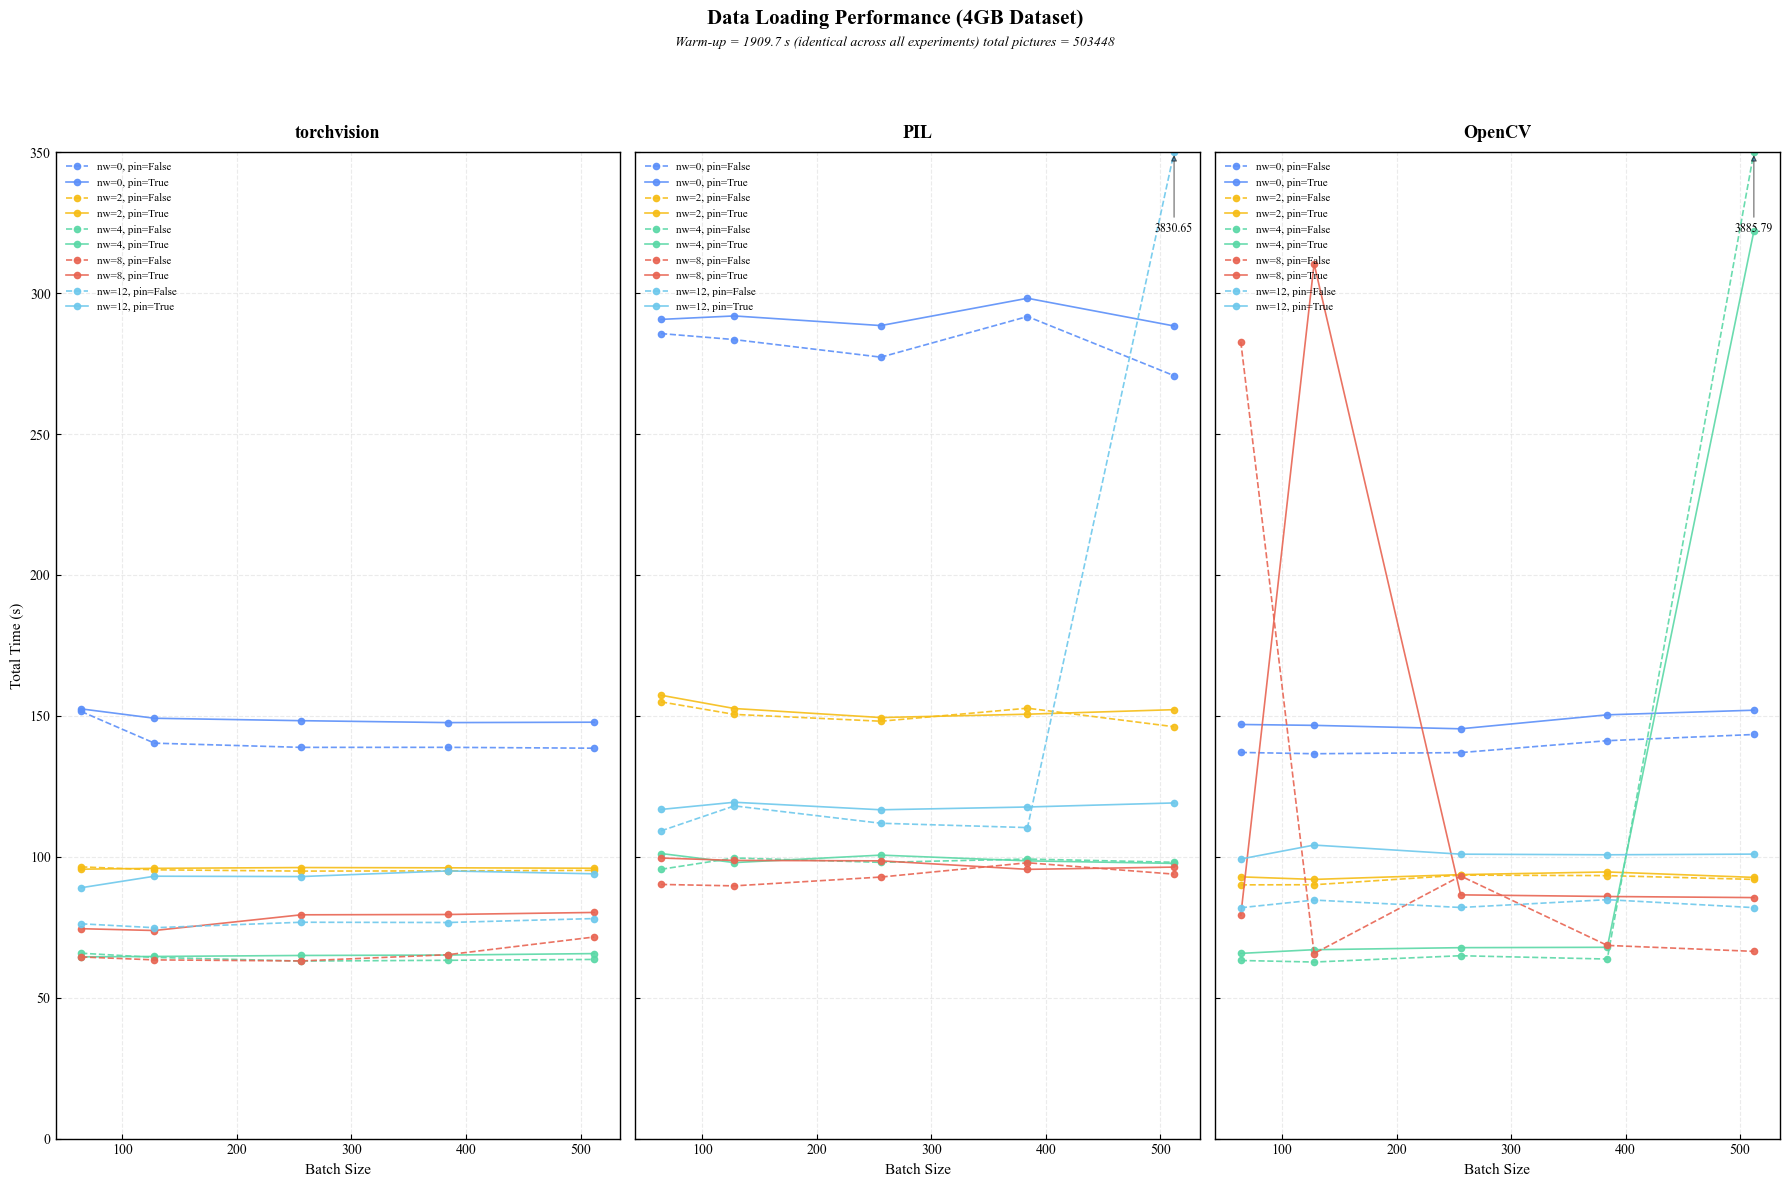

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

log_file = "./results/log_4GB.txt"

pattern = re.compile(
    r"method:\s*(\w+),\s*num_workers:\s*(\d+),\s*batch_size:\s*(\d+),\s*pin_memory:\s*(\w+)\s*[\r\n]+"
    r"Total:\s*([\d\.]+)s",
    re.MULTILINE
)

rows = []
with open(log_file, "r", encoding="utf-8") as f:
    text = f.read()
    for m in pattern.finditer(text):
        method, nw, bs, pin, total = m.groups()
        rows.append({
            "method": method,
            "num_workers": int(nw),
            "batch_size": int(bs),
            "pin_memory": (pin == "True"),
            "total_time": float(total)
        })

df = pd.DataFrame(rows)
df = df.sort_values(["method", "num_workers", "pin_memory", "batch_size"]).reset_index(drop=True)

YMAX = 350.0
df["plot_time"] = df["total_time"]
df["true_note"] = None

# OpenCV 异常点
mask_opencv_over = (df["method"] == "OpenCV") & (df["total_time"] > YMAX)
df.loc[mask_opencv_over, "true_note"] = df.loc[mask_opencv_over, "total_time"].round(2).astype(str)
df.loc[mask_opencv_over, "plot_time"] = YMAX

# PIL 异常点
mask_pil_over = (df["method"] == "PIL") & (df["total_time"] > YMAX)
df.loc[mask_pil_over, "true_note"] = df.loc[mask_pil_over, "total_time"].round(2).astype(str)
df.loc[mask_pil_over, "plot_time"] = YMAX

mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.linewidth"] = 1.0
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"

colors = {
    0: "#5B8FF9",
    2: "#F6BD16",
    4: "#5AD8A6",
    8: "#E86452",
    12: "#6DC8EC"
}
methods = ["torchvision", "PIL", "OpenCV"]

fig, axes = plt.subplots(1, 3, figsize=(18, 12), sharey=True)
for ax, method in zip(axes, methods):
    sub = df[df["method"] == method]
    if sub.empty:
        ax.set_title(method)
        continue

    for nw in sorted(sub["num_workers"].unique()):
        for pin, ls in ((False, "--"), (True, "-")):
            data = sub[(sub["num_workers"] == nw) & (sub["pin_memory"] == pin)]
            if data.empty:
                continue
            data = data.sort_values("batch_size")

            ax.plot(
                data["batch_size"],
                data["plot_time"],
                linestyle=ls,
                linewidth=1.2,
                color=colors.get(nw, "gray"),
                marker="o",
                markersize=4.5,
                alpha=0.9,
                label=f"nw={nw}, pin={pin}"
            )

            # 标注被截断的点
            capped_pts = data.dropna(subset=["true_note"])
            for _, r in capped_pts.iterrows():
                ax.annotate(
                    r["true_note"],
                    xy=(r["batch_size"], r["plot_time"]),
                    xytext=(r["batch_size"], r["plot_time"] - 25),
                    ha="center", va="top",
                    fontsize=8.5,
                    arrowprops=dict(arrowstyle="-|>", lw=0.8, alpha=0.6)
                )

    ax.set_title(method, fontsize=13, fontweight="bold", pad=10)
    ax.set_xlabel("Batch Size", fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.25)
    ax.set_ylim(0, YMAX)

axes[0].set_ylabel("Total Time (s)", fontsize=11)

# 独立 legend，放右上角
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), fontsize=8, loc="upper left", frameon=False, ncol=1)

fig.suptitle("Data Loading Performance (4GB Dataset)",
             fontsize=15, fontweight="bold", y=0.985)

# 把 Warm-up 注释放低一些，避免和标题重叠
fig.text(0.5, 0.955,
         "Warm-up = 1909.7 s (identical across all experiments) total pictures = 503448",
         ha="center", fontsize=10, style="italic")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("./results/comparison_4GB.png", dpi=400, bbox_inches="tight")
plt.show()
